In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

## download prepare and inspect data

In [2]:
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# data = load_dataset('google/speech_commands', 'v0.01', split=['train','test'], trust_remote_code=True)
train_set = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)
test_set = load_dataset('google/speech_commands', 'v0.01', split='test', trust_remote_code=True)

In [3]:
# inspect the raw dataset
print(type(train_set))
print("tain_set:\n", train_set)
print("test_set:\n", test_set)
print("labels: " ,np.sort(train_set.unique("label")))

<class 'datasets.arrow_dataset.Dataset'>
tain_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 51093
})
test_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 3081
})
labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


#### subsample the dataset

In [4]:
num_subsample_labels = 5
subsample_labels = np.sort(train_set.unique("label"))[:num_subsample_labels]
train_set = train_set.filter(lambda x: x['label'] in subsample_labels)
test_set = test_set.filter(lambda x: x['label'] in subsample_labels)
print("tain_set:\n", train_set)
print("test_set:\n", test_set)

tain_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 9237
})
test_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 1300
})


#### kernels for the Tuning Curves

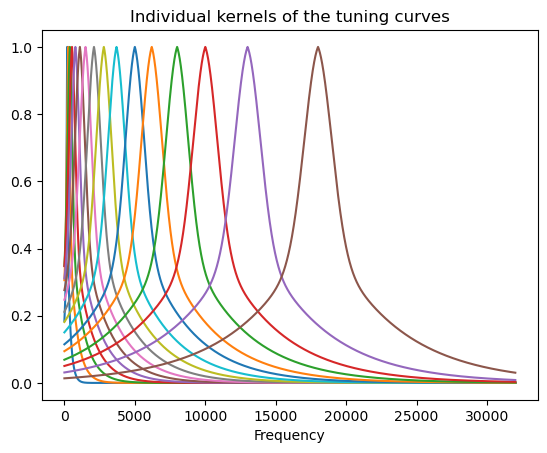

In [5]:
from utils import create_individual_kernel
sr = 16000
wave_length = 16000

# create tuning curves kernels
params = [
    (200, 40, 200),
    (520, 104, 280),
    (840, 168, 390),
    (1160, 232, 540),
    (1480, 296, 780),
    (1800, 360, 1100),
    (2120, 424, 1500),
    (2440, 488, 2100),
    (2760, 552, 2800),
    (3080, 616, 3700),
    (3400, 680, 5000),
    (3720, 744, 6200),
    (4040, 808, 8000),
    (4360, 872, 10000),
    (4680, 936, 13000),
    (5000, 1000, 18000)
]
kernels = [create_individual_kernel(wave_length*2 ,*p) for p in params]
for k in kernels:
    plt.plot(k)
plt.title("Individual kernels of the tuning curves")
plt.xlabel("Frequency")
plt.show()

#### preprocessing pipeline

In [6]:
from spike_encoding import convert_audio_to_spectrogram, \
    generate_spike_trains_IF, generate_spike_trains_poisson, \
    apply_TCs_kernels, rbf_encode_specs, \
    encode_to_spikes_TCs, encode_to_spikes_rbf # convenience functions with default parameters

# prepare the data loader
max_length = 16000  # or your desired length
all_labels = train_set['label']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
print("all_labels:", np.unique(all_labels))
print("encoded_labels:", np.unique(encoded_labels))

def collate_fn_base(batch):
    max_length = 16000
    # waveforms, labels = zip(*[(item[0].squeeze()[:max_length], item[2]) for item in batch])
    waveforms, labels = zip(*[(torch.tensor(item['audio']['array'][:max_length]) , item['label'])
                              for item in batch])
    # Ensure each waveform is 1D before padding
    waveforms = [waveform if waveform.ndim == 1 else waveform.mean(dim=0) for waveform in waveforms]

    #print("Shapes before padding:", [w.shape for w in waveforms])  # Add this line

    waveforms_padded = pad_sequence(waveforms, batch_first=True, padding_value=0)

    labels = label_encoder.transform(labels)  # Encode the labels as integers

    labels = torch.tensor(labels)
    return waveforms_padded, labels

def collate_fn_encoded_TCs(batch):
    waveforms_padded, labels = collate_fn_base(batch)
    specs, freqs = convert_audio_to_spectrogram(waveforms_padded, sr)
    spike_probs = apply_TCs_kernels(specs, freqs, kernels)

    # normalize specs across batch
    # (mean=0, std=1)
    spike_probs = (spike_probs - spike_probs.mean()) / spike_probs.std()
    # normalize to [0,1]
    spike_probs = (spike_probs - spike_probs.min()) / (spike_probs.max() - spike_probs.min())

    spike_prob_scale = 2.0
    v_th = 1.0
    tau_m = 0.3
    leaky = False
    spikes = generate_spike_trains_IF(spike_probs * spike_prob_scale, tau_m=tau_m, V_th=v_th, leaky=leaky)
    
    x = spikes
    x = torch.tensor(x, dtype=torch.float32)
    return x, labels

def collate_fn_encoded_rbfs(batch):
    waveforms_padded, labels = collate_fn_base(batch)
    specs, freqs = convert_audio_to_spectrogram(waveforms_padded, sr)
    spike_probs = rbf_encode_specs(specs, num_rbf=16, sigma=1.0)

    # normalize specs across batch
    # (mean=0, std=1)
    spike_probs = (spike_probs - spike_probs.mean()) / spike_probs.std()
    # normalize to [0,1]
    spike_probs = (spike_probs - spike_probs.min()) / (specs.max() - spike_probs.min())

    spike_prob_scale = 2.0
    v_th = 1.0
    tau_m = 0.7
    leaky = False
    spikes = generate_spike_trains_IF(spike_probs * spike_prob_scale, tau_m=tau_m, V_th=v_th, leaky=leaky)
    
    x = spikes
    x = torch.tensor(x, dtype=torch.float32)
    return x, labels

all_labels: [0 1 2 3 4]
encoded_labels: [0 1 2 3 4]


sample batch:
shape: torch.Size([64, 16, 64]) torch.Size([64])


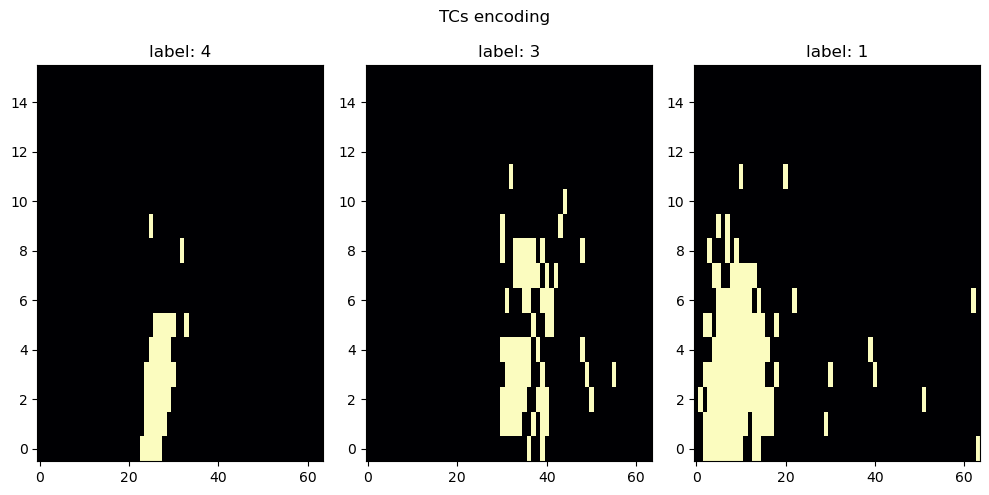

sample batch:
shape: torch.Size([64, 16, 64]) torch.Size([64])


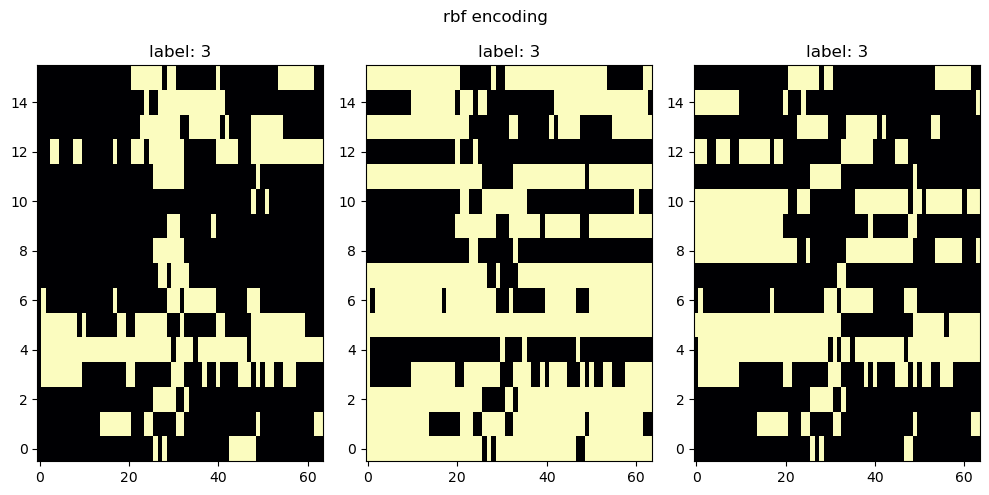

In [7]:
# TCs encoding
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_encoded_TCs, drop_last=True)
# show samples
sample_batch = next(iter(train_loader))
# inspect one sample and its label
sample_inputs = sample_batch[0]
print("sample batch:")
print("shape:", sample_batch[0].shape, sample_batch[1].shape)

plt.figure(figsize=(10, 5))
plt.suptitle("TCs encoding")
for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(sample_inputs[idx].numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"label: {sample_batch[1][idx].item()}")

plt.tight_layout()
plt.show()

# RBF encoding
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_encoded_rbfs, drop_last=True)
# show samples
sample_batch = next(iter(train_loader))
# inspect one sample and its label
sample_inputs = sample_batch[0]
print("sample batch:")
print("shape:", sample_batch[0].shape, sample_batch[1].shape)

plt.figure(figsize=(10, 5))
plt.suptitle("rbf encoding")
for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(sample_inputs[idx].numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"label: {sample_batch[1][idx].item()}")

plt.tight_layout()
plt.show()

## tuning curves and rbfs, encode raw audio to spikes (steps)

In [8]:
train_loader_raw = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_base, drop_last=True)
# # play the audio
# import IPython.display as ipd
# import scipy.io.wavfile
# ipd.Audio(sample_batch[0][0].numpy(), rate=16000)
# scipy.io.wavfile.write('sample.wav', 16000, sample_batch[0][0].numpy())

# helper plot function
def plot_neuros_timesteps(image, title=""):
    plt.imshow(image, aspect='auto', origin='lower', cmap='magma')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Neuron Index')
    plt.colorbar()

(64, 16, 127)


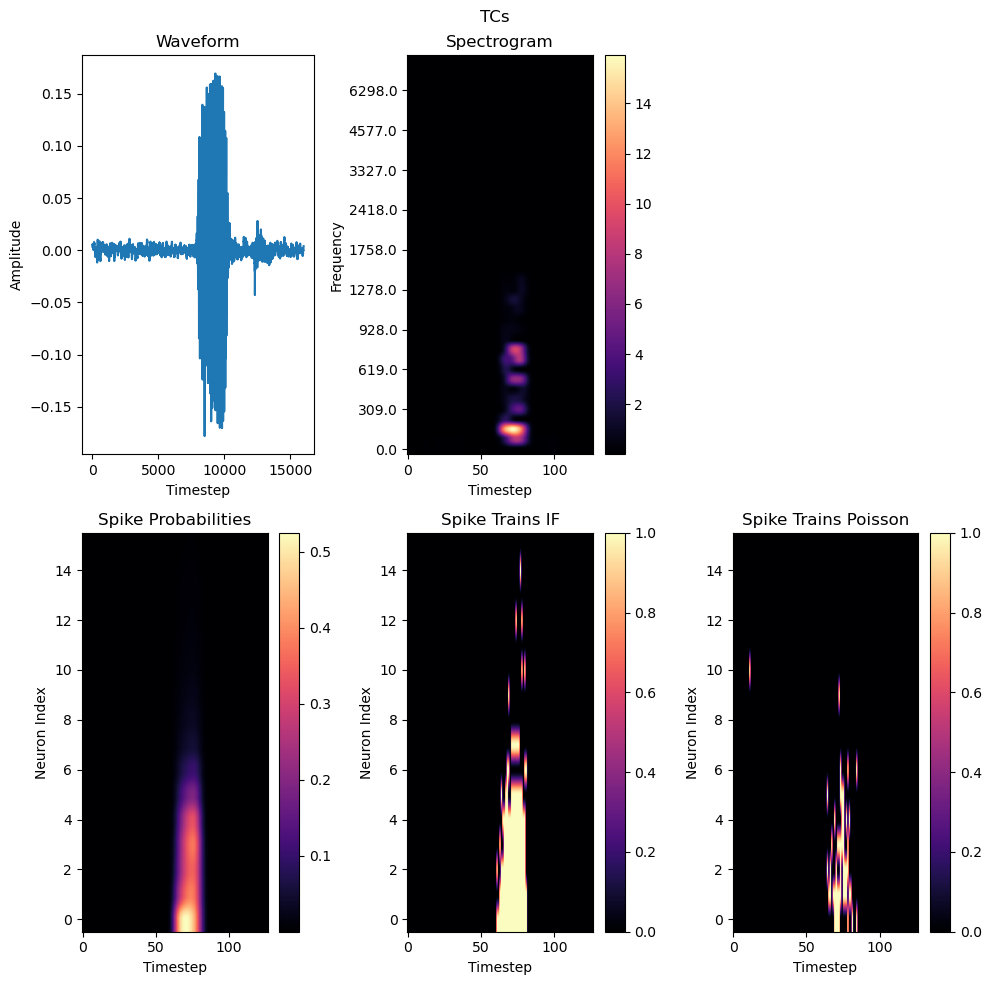

(64, 16, 127)


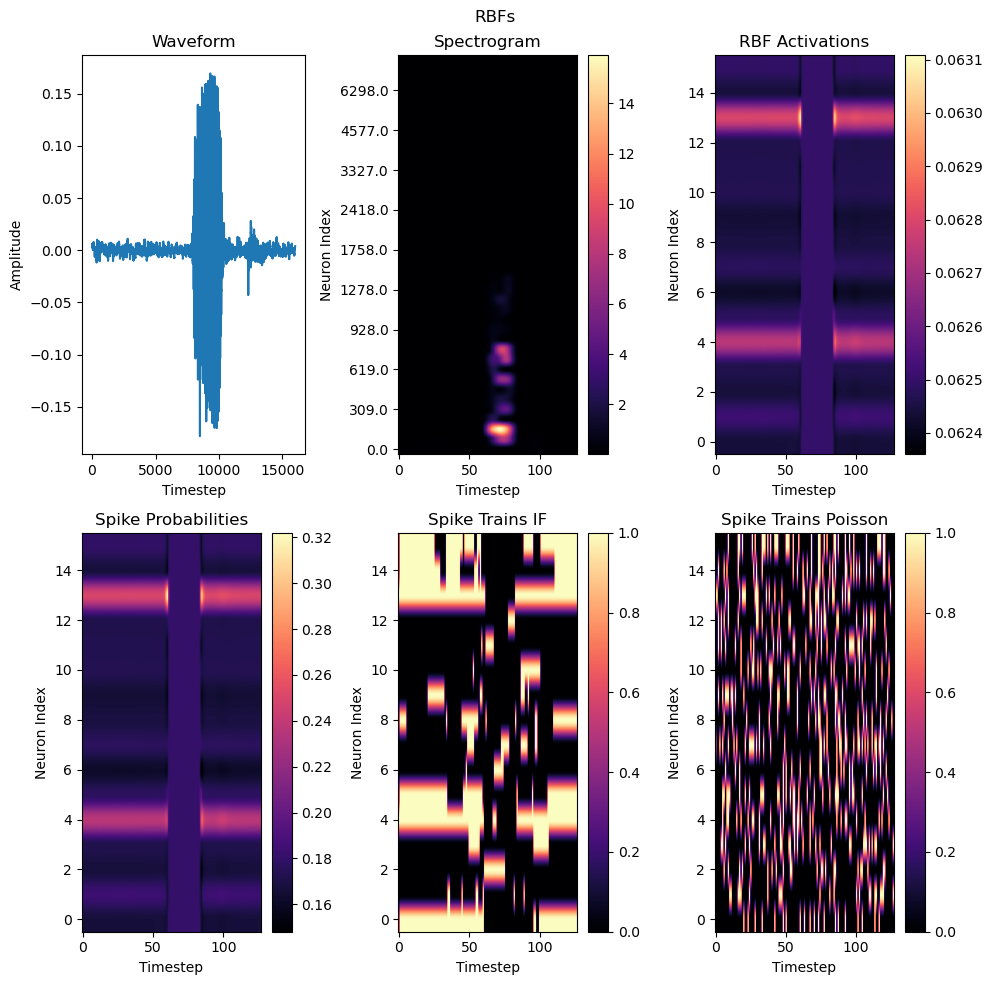

In [9]:
sample_batch_raw = next(iter(train_loader_raw))
sample_inputs_raw = sample_batch_raw[0]
sample_spikes_IF, spikes_probs, specs, spec_fr = encode_to_spikes_TCs(sample_inputs_raw,
                                                              kernels,
                                                              spike_prob_scale=2,
                                                              spike_encoding='IF')
sample_spikes_poisson, _, _, _ = encode_to_spikes_TCs(sample_inputs_raw,
                                                              kernels,
                                                              spike_prob_scale=2,
                                                              spike_encoding='poisson')
print(sample_spikes_IF.shape)

plt.figure(figsize=(10, 10))
plt.suptitle('TCs')

plt.subplot(2, 3, 1)
plt.plot(sample_inputs_raw[0].numpy())
plt.title('Waveform')
plt.xlabel('Timestep')
plt.ylabel('Amplitude')

plt.subplot(2, 3, 2)
plt.imshow(specs[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.xlabel('Timestep')
plt.ylabel('Frequency')
plt.colorbar()
# put the frequency on the y-axis
plt.yticks(np.arange(0, len(spec_fr), len(spec_fr)//10), np.round(spec_fr[::len(spec_fr)//10], 0))

plt.subplot(2, 3, 4)
plot_neuros_timesteps(spikes_probs[0], title='Spike Probabilities')
plt.subplot(2, 3, 5)
plot_neuros_timesteps(sample_spikes_IF[0], title='Spike Trains IF')
plt.subplot(2, 3, 6)
plot_neuros_timesteps(sample_spikes_poisson[0], title='Spike Trains Poisson')

plt.tight_layout()
plt.show()

# # inspect the spike trains from rbfs
sample_spikes_IF, spikes_probs, rbf_activations, specs, freqs = encode_to_spikes_rbf(sample_inputs_raw, 16000, spike_encoding='IF')
sample_spikes_poisson, _, _, _, _ = encode_to_spikes_rbf(sample_inputs_raw, 16000, spike_encoding='poisson')
print(sample_spikes_IF.shape)

plt.figure(figsize=(10, 10))
plt.suptitle('RBFs')

plt.subplot(2, 3, 1)
plt.plot(sample_inputs_raw[0].numpy())
plt.title('Waveform')
plt.xlabel('Timestep')
plt.ylabel('Amplitude')

plt.subplot(2, 3, 2)
plt.imshow(specs[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.xlabel('Timestep')
plt.ylabel('Neuron Index')
plt.colorbar()
# put the frequency on the y-axis
plt.yticks(np.arange(0, len(freqs), len(freqs)//10), np.round(freqs[::len(freqs)//10], 0))

plt.subplot(2, 3, 3)
plot_neuros_timesteps(rbf_activations[0], title='RBF Activations')
plt.subplot(2, 3, 4)
plot_neuros_timesteps(spikes_probs[0], title='Spike Probabilities')
plt.subplot(2, 3, 5)
plot_neuros_timesteps(sample_spikes_IF[0], title='Spike Trains IF')
plt.subplot(2, 3, 6)
plot_neuros_timesteps(sample_spikes_poisson[0], title='Spike Trains Poisson')

plt.tight_layout()
plt.show()

## training SNNs

#### 1. spikingjelly network

In [ ]:
from models import SJNetwork
from spikingjelly.activation_based import functional, surrogate, neuron
 
import os
import sys
from torch.utils.tensorboard import SummaryWriter
import time
import datetime
from torch.amp import GradScaler, autocast
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_encoded_TCs, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn_encoded_TCs, drop_last=True)

out_dir = "logs/TCs_IF_" + str(num_subsample_labels)
os.makedirs(out_dir, exist_ok=True)

input_size = sample_inputs.shape[1]
num_classes = len(np.unique(encoded_labels))

channels = 24
lr = 1e-3
epochs = 30

print("num classes: ", num_classes)
print("input vectors size (per timestep): ", input_size)
print("one data point shape: ", sample_inputs[0].shape)

# create the network
model = SJNetwork(channels=channels,
                output_size=num_classes,
                spiking_neuron=neuron.LIFNode, surrogate_function=surrogate.ATan(), detach_reset=True)
functional.set_step_mode(model, 'm')

model.to(device)

scaler = GradScaler(device=device)
start_epoch = 0
max_test_acc = -1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

writer = SummaryWriter(out_dir, purge_step=start_epoch)

# print(model)
max_iter = np.inf
for epoch in tqdm(range(start_epoch, epochs), desc='epochs', leave=True):
    start_time = time.time()
    model.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    iteration = 0
    for input, label in tqdm(train_loader, desc='train-iteration', leave=False):
    # for frame, label in tqdm(surrogate_data, desc='train-iteration', leave=False):
        if iteration > max_iter:
            break
        iteration += 1
        optimizer.zero_grad()
        if isinstance(input, np.ndarray):
            input = torch.tensor(input, dtype=torch.float32)
        # shape of frame(1d) is [Batch, X, Timesteps]
        # wanted shape is [Timesteps, Batch, channels, X]
        
        input = input.transpose(0, 2).transpose(1, 2)
        input = input.unsqueeze(2)
        input = input.to(device)
            
        label = label.to(device)
        label_onehot = F.one_hot(label, num_classes).float()

        if scaler is not None:
            out_fr = model(input).mean(0)

            loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = model(input).mean(0)

            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        functional.reset_net(model)

    train_time = time.time()
    train_speed = train_samples / (train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    lr_scheduler.step()

    model.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        iteration = 0
        for input, label in tqdm(test_loader, desc='test-iteration', leave=False):
            if iteration > max_iter:
                break
            iteration += 1
            if isinstance(input, np.ndarray):
                input = torch.tensor(input, dtype=torch.float32)
            # shape of frame(1d) is [Batch, X, Timesteps]
            # wanted shape is [Timesteps, Batch, channels, X]
            input = input.transpose(0, 2).transpose(1, 2)
            input = input.unsqueeze(2)
            input = input.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, num_classes).float()
            out_fr = model(input).mean(0)
            loss = F.mse_loss(out_fr, label_onehot)
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(model)
    test_time = time.time()
    test_speed = test_samples / (test_time - train_time)
    test_loss /= test_samples
    test_acc /= test_samples
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_acc', test_acc, epoch)

    save_max = False
    if test_acc > max_test_acc:
        max_test_acc = test_acc
        save_max = True

    checkpoint = {
        'net': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'max_test_acc': max_test_acc
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))

    print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}')
    print(f'lr = {lr_scheduler.get_last_lr()[0]}, max_test_acc ={max_test_acc: .4f}, ')
    # print(f'train speed ={train_speed: .4f} input/s, test speed ={test_speed: .4f} input/s')
    # print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (epochs - epoch))).strftime("%Y-%m-%d %H:%M:%S")}\n')

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

def load_tensorboard_logs(logdir):
    # Load the TensorBoard logs using EventAccumulator
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()  # Load the events from the log directory

    # Get the list of scalars (tags) available
    tags = event_acc.Tags()["scalars"]
    
    # Retrieve scalar data for each tag
    scalar_data = {}
    for tag in tags:
        scalar_data[tag] = event_acc.Scalars(tag)
    
    return scalar_data

# Example usage: Load data from a specific run directory
logdir = 'logs/TCs_mel_3'
data = load_tensorboard_logs(logdir)

# Extract train and test accuracy for analysis
train_acc = data['train_acc']  # List of events (step, value, wall_time)
test_acc = data['test_acc']
train_loss = data['train_loss']
test_loss = data['test_loss']

# Print or process the values
print("Train Accuracy:")
for event in train_acc:
    print(f"Step: {event.step}, Accuracy: {event.value}")

print("Test Accuracy:")
for event in test_acc:
    print(f"Step: {event.step}, Accuracy: {event.value}")


#### 2. snntorch network

In [ ]:
# updated version with batch norm and decaying learning rate
from models import customSNet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_encoded_TCs, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn_encoded_TCs, drop_last=True)

# Hyperparameters
num_steps = 20
beta = 0.9
num_class = 35
learning_rate = 0.001
num_epochs = 10  # Adjust based on your needs

# Initialize model, loss, optimizer, and scheduler
model = customSNet(num_steps=num_steps, beta=beta, num_class=num_class)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


# Example Training Loop with Validation
for epoch in tqdm(range(num_epochs), desc='Epoch', total=num_epochs, leave=True):
    model.train()
    running_loss = 0.0
    for input, labels in tqdm(train_loader, desc='Iteration', total=len(train_loader), leave=False):
        input = input.unsqueeze(1)

        optimizer.zero_grad()
        output, _ = model(input)
        # Aggregate outputs over time steps, e.g., mean
        output_mean = output.mean(dim=0)
        labels = labels.long()
        loss = loss_fn(output_mean, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * input.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for input, labels in test_loader:
            input = input.unsqueeze(1)
            output, _ = model(input)
            output_mean = output.mean(dim=0)
            preds = output_mean.argmax(dim=1)
            labels = labels.long()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    
    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")